# 1. 라이브러리 임포트 및 이미지 확인

number of train examples : 1000


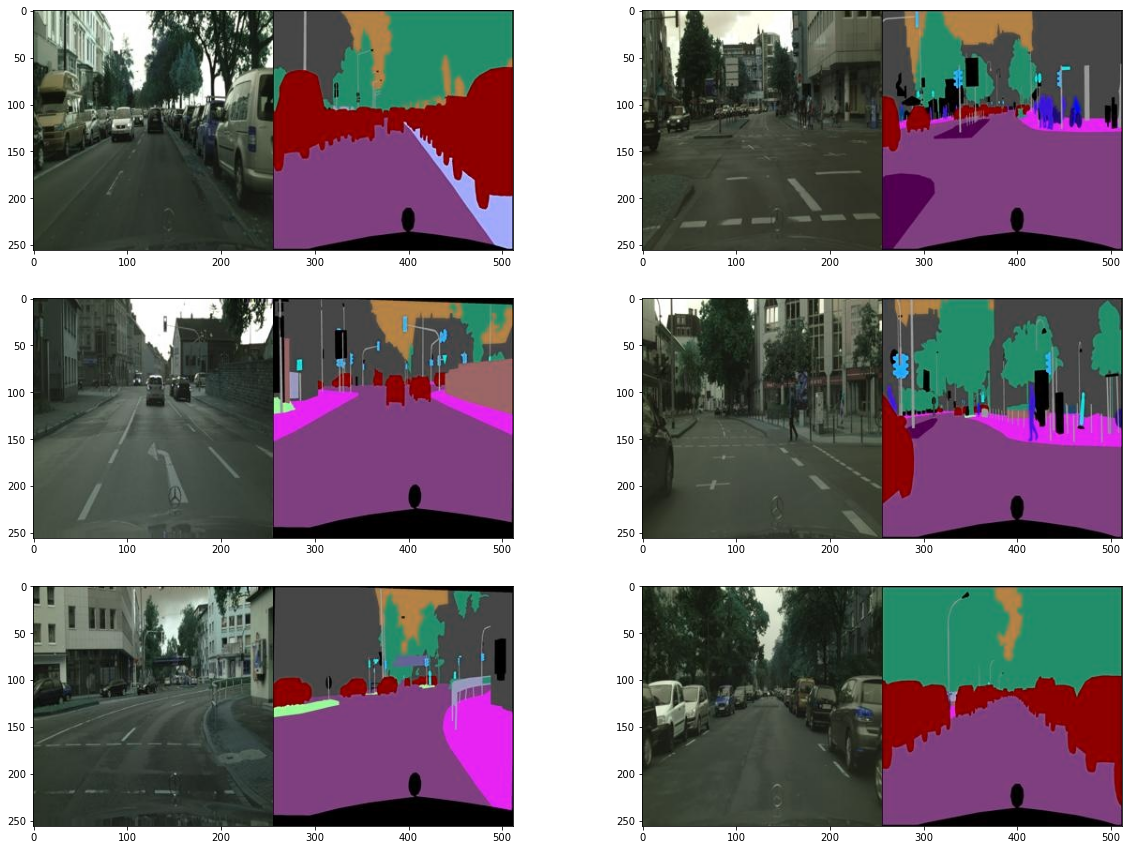

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers


data_path = 'cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

# 2. 데이터 전처리 및 증강 후 데이터셋 준비

In [2]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

@tf.function()
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:
        padded = tf.pad(stacked, _pad, "REFLECT")
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]  

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

# 3. pix2pix 모델 준비
## 3.1 블록 준비

In [3]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

## 3.2 UNet Generator 준비

In [4]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

UNetGenerator().get_summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block (EncodeBlock)      (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
encode_block_1 (EncodeBlock)    (None, 64, 64, 128)  131584      encode_block[0][0]               
__________________________________________________________________________________________________
encode_block_2 (EncodeBlock)    (None, 32, 32, 256)  525312      encode_block_1[0][0]             
______________________________________________________________________________________________

## 3.3 판별자 준비

In [5]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    
Discriminator().get_summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

# 4. 학습
## 4.1 비용/최적화기 정의 및 학습 과정 정의 

In [6]:
def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        fake_colored = generator(sketch, training=True)
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss)
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss


bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)




## 4.2 학습

In [7]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:0.7972                     
L1_loss:0.3399                     
Discriminator_loss:1.3746

EPOCH[1] - STEP[20]                     
Generator_loss:0.8997                     
L1_loss:0.3092                     
Discriminator_loss:1.1661

EPOCH[1] - STEP[30]                     
Generator_loss:1.1894                     
L1_loss:0.2764                     
Discriminator_loss:1.1797

EPOCH[1] - STEP[40]                     
Generator_loss:1.2090                     
L1_loss:0.2818                     
Discriminator_loss:0.9440

EPOCH[1] - STEP[50]                     
Generator_loss:1.7632                     
L1_loss:0.2449                     
Discriminator_loss:0.7757

EPOCH[1] - STEP[60]                     
Generator_loss:1.8602                     
L1_loss:0.2336                     
Discriminator_loss:0.4737

EPOCH[1] - STEP[70]                     
Generator_loss:1.4612                     
L1_loss:0.2171                    

EPOCH[3] - STEP[70]                     
Generator_loss:2.4141                     
L1_loss:0.2029                     
Discriminator_loss:0.6317

EPOCH[3] - STEP[80]                     
Generator_loss:1.2682                     
L1_loss:0.2370                     
Discriminator_loss:0.5437

EPOCH[3] - STEP[90]                     
Generator_loss:1.8385                     
L1_loss:0.1928                     
Discriminator_loss:0.5287

EPOCH[3] - STEP[100]                     
Generator_loss:1.3050                     
L1_loss:0.1908                     
Discriminator_loss:0.8308

EPOCH[3] - STEP[110]                     
Generator_loss:1.8185                     
L1_loss:0.2937                     
Discriminator_loss:0.7324

EPOCH[3] - STEP[120]                     
Generator_loss:1.0062                     
L1_loss:0.2154                     
Discriminator_loss:0.6735

EPOCH[3] - STEP[130]                     
Generator_loss:1.2514                     
L1_loss:0.2218                

EPOCH[5] - STEP[130]                     
Generator_loss:2.3763                     
L1_loss:0.2012                     
Discriminator_loss:0.4131

EPOCH[5] - STEP[140]                     
Generator_loss:1.0331                     
L1_loss:0.1908                     
Discriminator_loss:1.3233

EPOCH[5] - STEP[150]                     
Generator_loss:1.5092                     
L1_loss:0.2008                     
Discriminator_loss:0.5361

EPOCH[5] - STEP[160]                     
Generator_loss:1.6258                     
L1_loss:0.1834                     
Discriminator_loss:0.9362

EPOCH[5] - STEP[170]                     
Generator_loss:1.0241                     
L1_loss:0.2012                     
Discriminator_loss:0.7476

EPOCH[5] - STEP[180]                     
Generator_loss:1.7792                     
L1_loss:0.1933                     
Discriminator_loss:0.4746

EPOCH[5] - STEP[190]                     
Generator_loss:0.3082                     
L1_loss:0.2583             

EPOCH[7] - STEP[190]                     
Generator_loss:1.0367                     
L1_loss:0.1620                     
Discriminator_loss:0.9128

EPOCH[7] - STEP[200]                     
Generator_loss:1.5033                     
L1_loss:0.2031                     
Discriminator_loss:0.5211

EPOCH[7] - STEP[210]                     
Generator_loss:1.2162                     
L1_loss:0.1930                     
Discriminator_loss:0.9167

EPOCH[7] - STEP[220]                     
Generator_loss:3.1963                     
L1_loss:0.1814                     
Discriminator_loss:3.1823

EPOCH[7] - STEP[230]                     
Generator_loss:1.3038                     
L1_loss:0.1797                     
Discriminator_loss:0.6370

EPOCH[7] - STEP[240]                     
Generator_loss:0.9808                     
L1_loss:0.1739                     
Discriminator_loss:0.7011

EPOCH[7] - STEP[250]                     
Generator_loss:1.8843                     
L1_loss:0.2079             

EPOCH[9] - STEP[250]                     
Generator_loss:2.4890                     
L1_loss:0.1735                     
Discriminator_loss:0.6419

EPOCH[10] - STEP[10]                     
Generator_loss:1.3246                     
L1_loss:0.1842                     
Discriminator_loss:0.4545

EPOCH[10] - STEP[20]                     
Generator_loss:1.1112                     
L1_loss:0.1500                     
Discriminator_loss:1.7845

EPOCH[10] - STEP[30]                     
Generator_loss:2.7372                     
L1_loss:0.1680                     
Discriminator_loss:2.2722

EPOCH[10] - STEP[40]                     
Generator_loss:3.1811                     
L1_loss:0.1799                     
Discriminator_loss:1.5347

EPOCH[10] - STEP[50]                     
Generator_loss:2.0875                     
L1_loss:0.1912                     
Discriminator_loss:0.4859

EPOCH[10] - STEP[60]                     
Generator_loss:2.9242                     
L1_loss:0.1828             

# 5. 모델 테스트

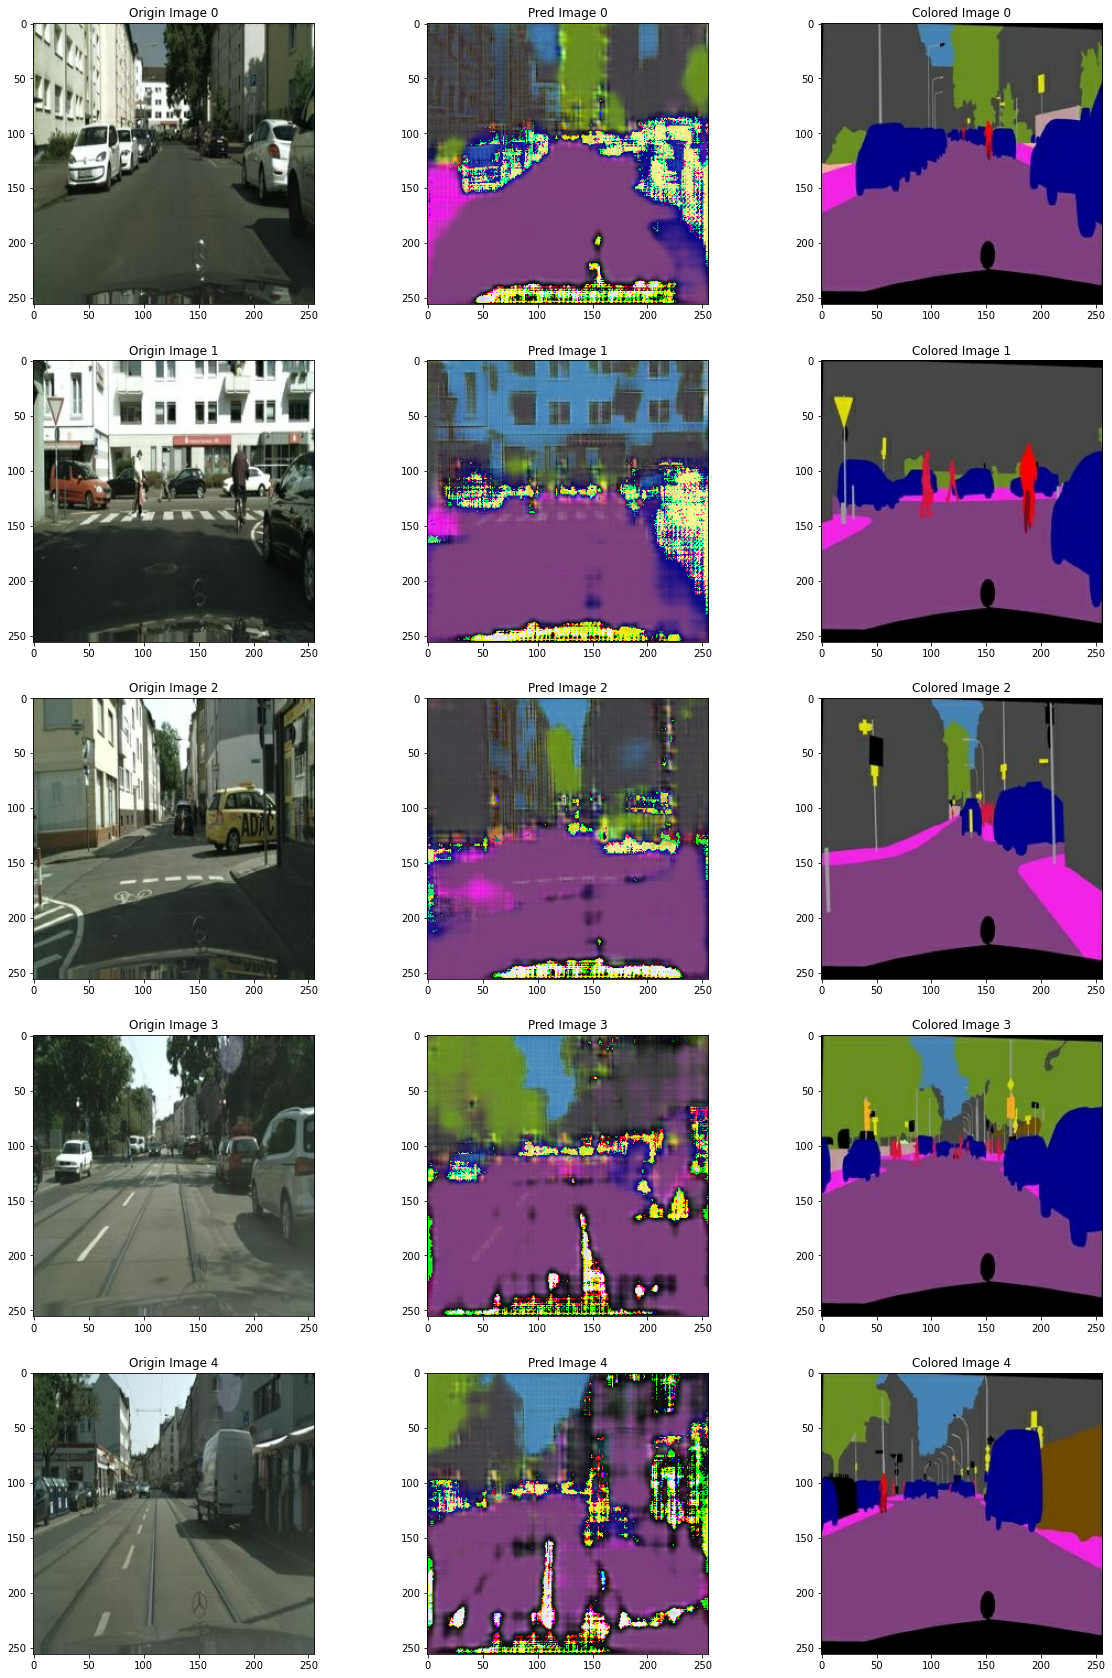

In [8]:
test_ind = 0
test_data_path = 'cityscapes/val/'

plt.figure(figsize=(20,30))
for i in range(1, 16, 3):
    f = test_data_path + os.listdir(test_data_path)[test_ind]

    origin, colored = load_img(f)

    pred = generator(tf.expand_dims(origin, 0))
    pred = denormalize(pred)    
    plt.subplot(5,3,i); plt.imshow(denormalize(origin)); plt.title(f"Origin Image {test_ind}")
    plt.subplot(5,3,i+1); plt.imshow(pred[0]); plt.title(f"Pred Image {test_ind}")
    plt.subplot(5,3,i+2); plt.imshow(denormalize(colored)); plt.title(f"Segmentation Map {test_ind}")
    test_ind += 1

# 6. 결과 정리
- 데이터 증강을 위해, crop, 회전, 뒤집기 등의 방법을 활용하여 데이터를 늘릴수가 있었습니다.
- Encoder/Decoder/Discriminator 블록을 이용하여 UNetGenerator와 Discriminator를 구현하였고, 학습을 진행하였습니다.
- 학습을 길게 진행하지 않아 원하는 아직 이미지를 얻지 못하였으나 세그먼테이션 맵이 약간씩 변화하는 모습을 확인할 수 있었습니다.